In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from PIL import Image

# Step 1: Define paths (replace with your actual dataset paths)
train_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

# Step 2: Data transformations (Resize to 224x224 for ResNet, normalize with ImageNet stats)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
full_train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Split train into train/validation (80/20)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoaders (batch size 64 for efficiency)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Class mapping (0: REAL, 1: FAKE)
class_names = full_train_dataset.classes

# Step 3: Model setup (ResNet18 with transfer learning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

# Freeze early layers for transfer learning
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: REAL or FAKE

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only train fc initially
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Optional: Unfreeze later layers after initial training (call this after a few epochs if needed)
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    return optimizer

# Step 4: Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        scheduler.step()

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return model

# Evaluation function (for val/test)
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = running_loss / len(loader)
    acc = correct / total
    return loss, acc

# Step 5: Train the model
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)

# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Step 6: Full evaluation on test set
def compute_metrics(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)

    # Confusion Matrix (2x2)
    conf_matrix = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            conf_matrix[i, j] = np.sum((y_true == i) & (y_pred == j))

    # Precision, Recall, F1 (for FAKE class, assuming 1 is positive)
    tp = conf_matrix[1, 1]
    fp = conf_matrix[0, 1]
    fn = conf_matrix[1, 0]
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision (FAKE): {precision:.4f}')
    print(f'Recall (FAKE): {recall:.4f}')
    print(f'F1-Score (FAKE): {f1:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)

    return conf_matrix

print('Test Evaluation:')
compute_metrics(model, test_loader)

# Step 7: Visual Explainability with Grad-CAM
# Unfreeze model parameters to allow gradient calculation for Grad-CAM
for param in model.parameters():
    param.requires_grad = True

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


KeyboardInterrupt: 

GRAD-CAM

In [ ]:
# ────────────────────────────────────────────────────────────────
# Comprehensive Evaluation & Visualization (post-training)
# Only run this after training and loading the best model
# ────────────────────────────────────────────────────────────────

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from PIL import Image
import os
import random
from matplotlib import cm

# Make sure these are defined (should already exist from previous cells)
# model, device, test_loader, transform, test_dir

# ─── 1. Compute all metrics + probabilities for ROC ────────────────────────

def compute_metrics_and_probs(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []           # softmax prob of FAKE class

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()   # P(FAKE)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Basic counts
    accuracy = (y_true == y_pred).mean()

    # Confusion matrix
    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    # Metrics (positive = FAKE = class 1)
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    print("\n" + "="*60)
    print("Final Test Set Evaluation")
    print("="*60)
    print(f"Accuracy:   {accuracy:.4f}")
    print(f"Precision:  {precision:.4f}  (for FAKE)")
    print(f"Recall:     {recall:.4f}     (for FAKE)")
    print(f"F1-Score:   {f1:.4f}        (for FAKE)")
    print("\nConfusion Matrix:")
    print(cm)
    print("="*60 + "\n")

    return cm, precision, recall, f1, accuracy, y_true, y_prob


# ─── 2. Plotting functions ────────────────────────────────────────────────

def plot_confusion_matrix(cm, class_names=['REAL', 'FAKE']):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


def plot_performance_bars(precision, recall, f1, acc):
    metrics = {'Accuracy': acc, 'Precision': precision,
               'Recall': recall, 'F1-Score': f1}
    plt.figure(figsize=(7, 4))
    bars = plt.bar(metrics.keys(), metrics.values(), color=['#4c72b0','#55a868','#c44e52','#8172b3'])
    plt.ylim(0, 1.05)
    plt.ylabel('Score')
    plt.title('Test Set Performance Metrics')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.015,
                 f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# ─── Modern Grad-CAM class with full_backward_hook (safer) ────────────────

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        # Use full_backward_hook (more reliable in newer PyTorch)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, inp, out):
        self.activations = out.detach()

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, x, target_class=None):
        self.model.eval()
        logit = self.model(x)

        if target_class is None:
            target_class = logit.argmax(dim=1).item()

        score = logit[0, target_class]
        self.model.zero_grad()
        score.backward()

        if self.gradients is None or self.activations is None:
            raise RuntimeError("Gradients or activations not captured – check hooks")

        grads = self.gradients[0]           # shape: C,H,W
        acts  = self.activations[0]         # shape: C,H,W

        weights = grads.mean(dim=(1,2), keepdim=True)   # Global Average Pool → C,1,1
        cam = (weights * acts).sum(dim=0).relu()        # H,W
        cam = cam / (cam.max() + 1e-8)
        return cam


# ─── Fixed visualization function ─────────────────────────────────────────

def show_gradcam_four_images():
    samples = get_four_samples(test_dir)
    if not samples:
        return

    print("\nSelected images for Grad-CAM visualization:")
    for p, c in samples:
        print(f"  • {os.path.basename(p):<20}  ({c})")

    # Initialize Grad-CAM
    target_layer = model.layer4[-1].conv2
    gradcam = GradCAM(model, target_layer)

    fig, axes = plt.subplots(4, 3, figsize=(12, 14))
    fig.suptitle("Grad-CAM Explanations – 2 REAL vs 2 FAKE", fontsize=16, y=0.98)

    for i, (img_path, label) in enumerate(samples):
        if not os.path.isfile(img_path):
            print(f"Missing file: {img_path}")
            continue

        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)

        try:
            cam = gradcam(input_tensor)
        except Exception as e:
            print(f"Grad-CAM failed for {os.path.basename(img_path)}: {e}")
            continue

        cam_np = cam.detach().cpu().numpy()
        cam_np = np.maximum(cam_np, 0)
        cam_np = cam_np / (cam_np.max() + 1e-8) if cam_np.max() > 0 else cam_np

        # Resize CAM to match image size
        cam_resized = np.array(Image.fromarray(cam_np).resize((224, 224), Image.BILINEAR))

        # ─── Modern colormap usage (fix for matplotlib ≥ 3.7) ────────
        cmap = plt.get_cmap('jet')              # or matplotlib.colormaps['jet']
        heatmap = cmap(cam_resized)[:, :, :3]   # (H,W,3) float [0,1]

        img_resized = np.array(img.resize((224, 224))) / 255.0   # normalize to [0,1]
        overlay = (0.40 * heatmap + 0.60 * img_resized).clip(0, 1)

        # Plot
        axes[i,0].imshow(img_resized)
        axes[i,0].set_title(f"Original\n{label}")
        axes[i,0].axis('off')

        axes[i,1].imshow(heatmap)
        axes[i,1].set_title("Grad-CAM Heatmap")
        axes[i,1].axis('off')

        axes[i,2].imshow(overlay)
        axes[i,2].set_title("Overlay")
        axes[i,2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# ─── Also update your get_four_samples if needed (make sure it finds files) ──

def get_four_samples(test_dir):
    real_path = os.path.join(test_dir, "REAL")
    fake_path = os.path.join(test_dir, "FAKE")

    real_imgs = [f for f in os.listdir(real_path)
                 if f.lower().endswith(('.jpg','.jpeg','.png'))]
    fake_imgs = [f for f in os.listdir(fake_path)
                 if f.lower().endswith(('.jpg','.jpeg','.png'))]

    if len(real_imgs) < 2 or len(fake_imgs) < 2:
        print("Not enough images found in test/REAL or test/FAKE")
        print(f"REAL count: {len(real_imgs)}, FAKE count: {len(fake_imgs)}")
        return []

    # First two REAL (sorted for reproducibility)
    real_sel = sorted(real_imgs)[:2]
    # Two random FAKE (for variety)
    fake_sel = random.sample(fake_imgs, min(2, len(fake_imgs)))

    samples = []
    for fn in real_sel:
        samples.append((os.path.join(real_path, fn), "REAL"))
    for fn in fake_sel:
        samples.append((os.path.join(fake_path, fn), "FAKE"))

    return samples



Selected images for Grad-CAM visualization:
  • 0000 (10).jpg         (REAL)
  • 0000 (2).jpg          (REAL)
  • 607 (2).jpg           (FAKE)
  • 91 (9).jpg            (FAKE)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


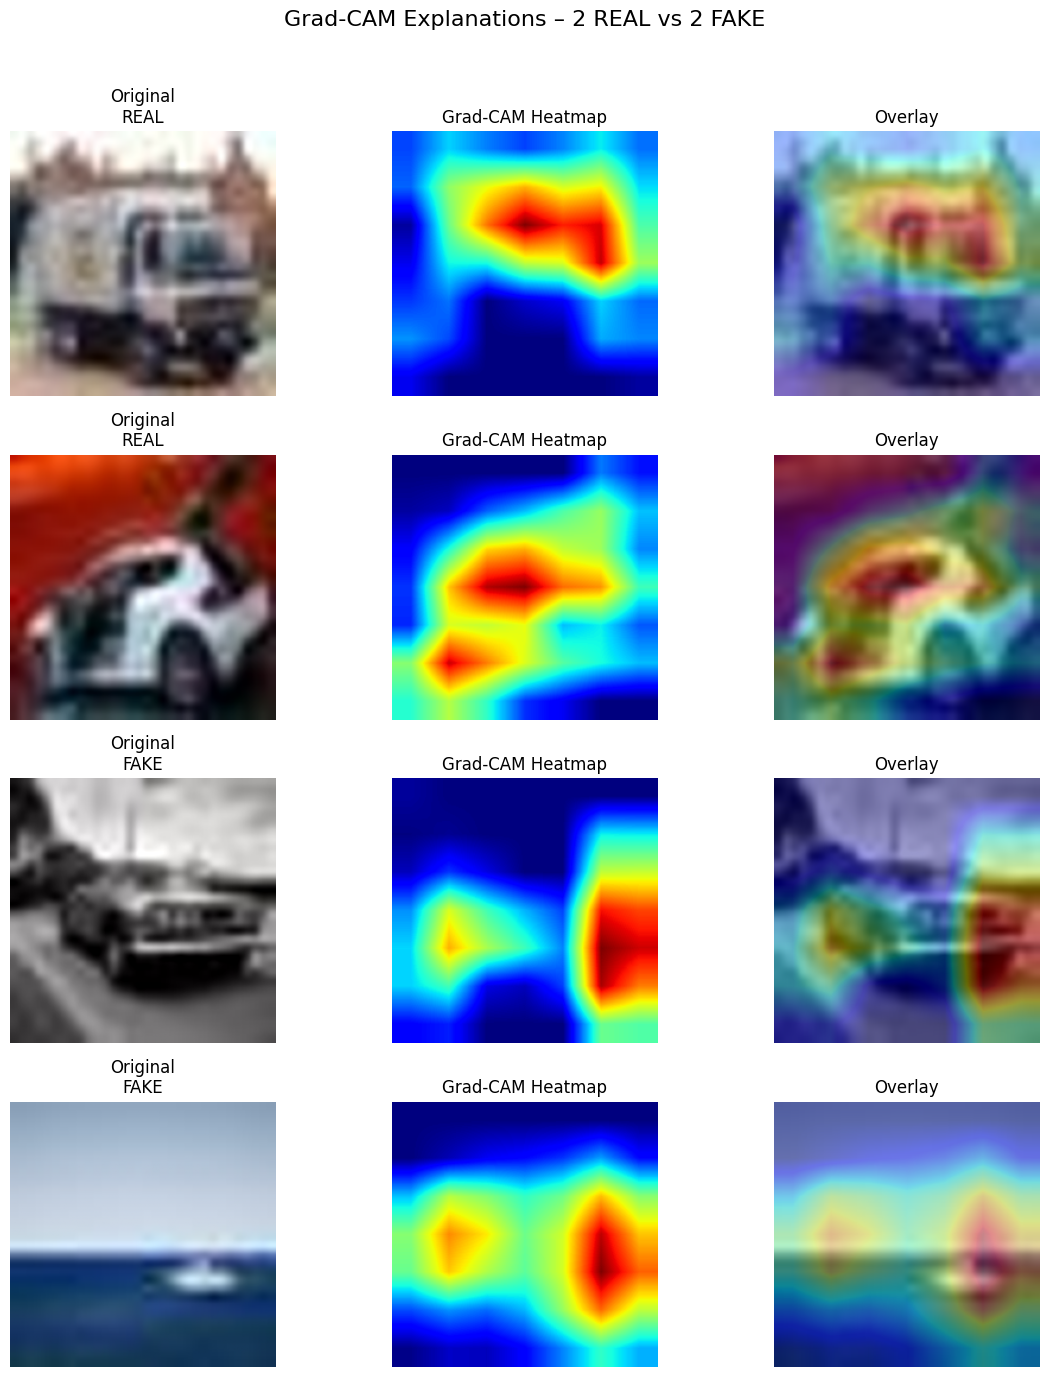

In [ ]:
model.eval()
show_gradcam_four_images()

PHASE 2


Selected sample with FAKE confidence: 0.9844
Selected sample with FAKE confidence: 0.9917
Selected sample with FAKE confidence: 0.9832
Original Prediction: 0
Real Confidence    : 0.01556222140789032
Fake Confidence    : 0.9844377636909485


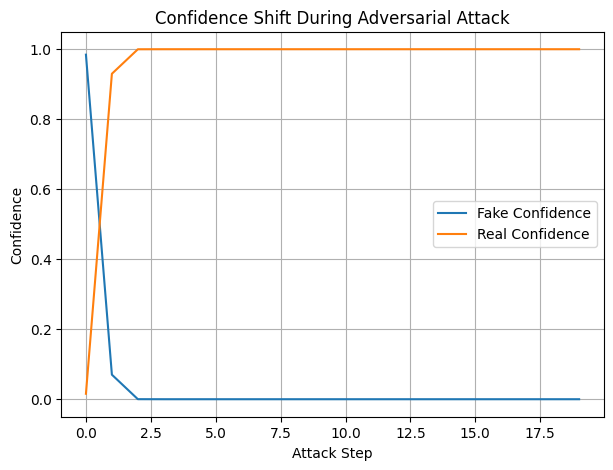

Final Prediction  : 1
Final Real Conf   : 1.0
Final Fake Conf   : 8.71099831800016e-20


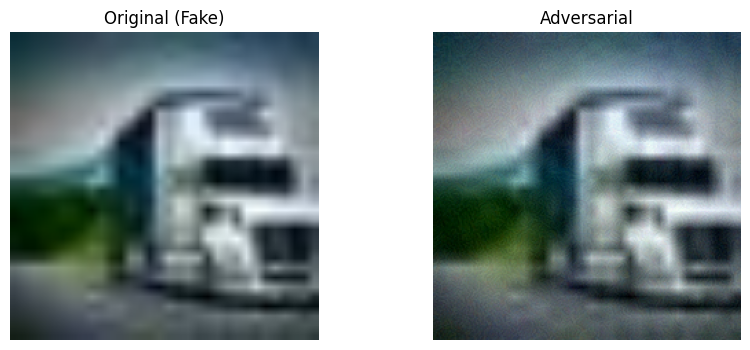

Average perturbation magnitude: 0.06346742808818817
L2 perturbation norm          : 30.213577270507812


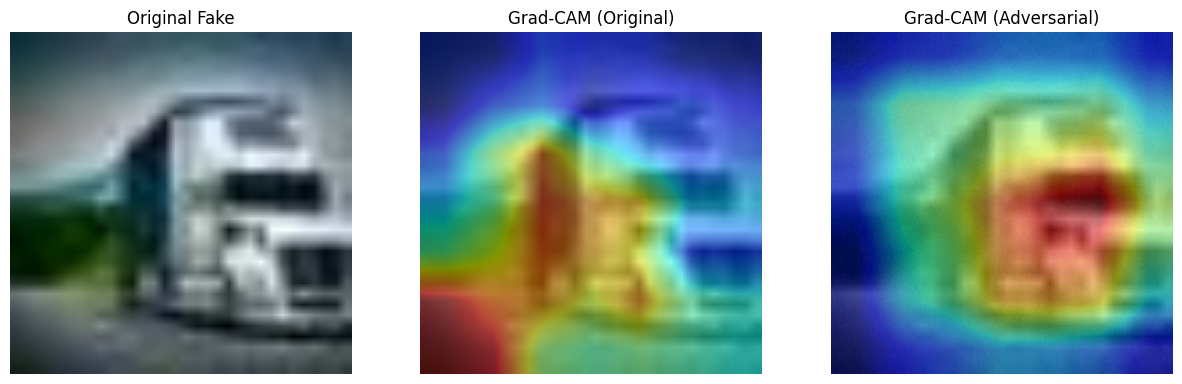

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ── Class index helpers (adjust if your folders are ordered differently) ──
# class_names from ImageFolder is alphabetical: ['FAKE', 'REAL'] → FAKE=0, REAL=1
# If your folder gives ['REAL','FAKE'] swap the indices below.
FAKE_IDX = class_names.index('FAKE') if 'FAKE' in class_names else 0
REAL_IDX = 1 - FAKE_IDX

# ── ImageNet denorm (ResNet uses ImageNet stats, NOT 0.5/0.5) ──────────────
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denorm(tensor):
    x = tensor.cpu().clone()
    x = x * IMAGENET_STD + IMAGENET_MEAN          # reverse ImageNet normalisation
    x = x.permute(1, 2, 0).numpy()
    return np.clip(x, 0, 1)

# ── 1. Select high-confidence FAKE samples ────────────────────────────────
def get_high_conf_fake_samples(model, loader, threshold=0.95, max_samples=3):
    model.eval()
    selected = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs   = F.softmax(outputs, dim=1)
            preds   = torch.argmax(probs, dim=1)
            for i in range(len(images)):
                if labels[i].item() == FAKE_IDX and preds[i].item() == FAKE_IDX:
                    confidence = probs[i][FAKE_IDX].item()
                    if confidence > threshold:
                        selected.append((images[i].unsqueeze(0), labels[i].unsqueeze(0)))
                        print(f"Selected sample with FAKE confidence: {confidence:.4f}")
                        if len(selected) >= max_samples:
                            return selected
    return selected

samples = get_high_conf_fake_samples(model, test_loader)
image, label = samples[0]

with torch.no_grad():
    output = model(image)
    probs  = F.softmax(output, dim=1)

print("Original Prediction:", torch.argmax(probs, dim=1).item())
print("Real Confidence    :", probs[0][REAL_IDX].item())
print("Fake Confidence    :", probs[0][FAKE_IDX].item())

# ── 2. Iterative FGSM (PGD) attack ───────────────────────────────────────
def iterative_fgsm(model, image, label, epsilon=0.15, alpha=0.02, steps=20):
    perturbed = image.clone().detach().to(device)
    original  = image.clone().detach().to(device)
    label     = label.to(device)
    trajectory = []

    for step in range(steps):
        perturbed.requires_grad = True
        outputs   = model(perturbed)
        probs     = F.softmax(outputs, dim=1)
        fake_conf = probs[0][FAKE_IDX].item()
        real_conf = probs[0][REAL_IDX].item()
        pred      = torch.argmax(probs, dim=1).item()
        trajectory.append((step, fake_conf, real_conf, pred))

        loss = F.cross_entropy(outputs, label)
        model.zero_grad()
        loss.backward()

        grad_sign = perturbed.grad.data.sign()
        perturbed = perturbed + alpha * grad_sign

        # Keep within epsilon-ball; clamp to valid ImageNet-normalised range
        eta       = torch.clamp(perturbed - original, min=-epsilon, max=epsilon)
        perturbed = torch.clamp(original + eta, min=-2.5, max=2.5).detach()

    return perturbed, trajectory

adv_image, trajectory = iterative_fgsm(model, image, label, epsilon=0.15, alpha=0.02, steps=20)

# ── 3. Confidence shift plot ──────────────────────────────────────────────
steps_list = [t[0] for t in trajectory]
fake_conf  = [t[1] for t in trajectory]
real_conf  = [t[2] for t in trajectory]

plt.figure(figsize=(7, 5))
plt.plot(steps_list, fake_conf, label="Fake Confidence")
plt.plot(steps_list, real_conf, label="Real Confidence")
plt.xlabel("Attack Step")
plt.ylabel("Confidence")
plt.title("Confidence Shift During Adversarial Attack")
plt.legend()
plt.grid()
plt.show()

# ── 4. Final prediction after attack ─────────────────────────────────────
with torch.no_grad():
    final_output = model(adv_image)
    final_probs  = F.softmax(final_output, dim=1)

print("Final Prediction  :", torch.argmax(final_probs, dim=1).item())
print("Final Real Conf   :", final_probs[0][REAL_IDX].item())
print("Final Fake Conf   :", final_probs[0][FAKE_IDX].item())

# ── 5. Original vs Adversarial image ─────────────────────────────────────
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(denorm(image[0]))
plt.title("Original (Fake)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(denorm(adv_image[0]))
plt.title("Adversarial")
plt.axis("off")

plt.show()

perturbation = (adv_image - image).abs().mean().item()
l2_norm      = torch.norm((adv_image - image).view(-1)).item()
print("Average perturbation magnitude:", perturbation)
print("L2 perturbation norm          :", l2_norm)

# ── 6. Grad-CAM ───────────────────────────────────────────────────────────
class GradCAM:
    def __init__(self, model, target_layer):
        self.model       = model
        self.gradients   = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_image, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_image)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        output[:, class_idx].backward()
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam     = torch.sum(weights * self.activations, dim=1)
        cam     = torch.relu(cam)
        cam     = cam.squeeze().detach().cpu().numpy()
        cam     = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# ResNet18 last conv block = model.layer4  (replaces model.features[8])
# ResNet outputs 7×7 maps → resize to 224×224 (not 64×64 like the custom CNN)
target_layer = model.layer4
grad_cam     = GradCAM(model, target_layer)

original_cam = grad_cam.generate(image)
adv_cam      = grad_cam.generate(adv_image)

original_cam = cv2.resize(original_cam, (224, 224))
adv_cam      = cv2.resize(adv_cam,      (224, 224))

# ── 7. Grad-CAM visualisation ─────────────────────────────────────────────
orig_img = denorm(image[0])
adv_img  = denorm(adv_image[0])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(orig_img)
plt.title("Original Fake")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(orig_img)
plt.imshow(original_cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM (Original)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(adv_img)
plt.imshow(adv_cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM (Adversarial)")
plt.axis("off")

plt.show()

PHASE 3

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# ── ImageNet clamp range (ResNet uses ImageNet stats, NOT -1/1) ───────────
# After ImageNet normalization, pixel values roughly fall in [-2.5, 2.5]
# so we clamp to that range instead of (-1, 1) used by the custom CNN.
CLAMP_MIN = -2.5
CLAMP_MAX =  2.5

# ── 1. FGSM for training (adds adversarial noise during training loop) ────
def fgsm_attack_train(model, images, labels, epsilon=0.05):
    images = images.clone().detach().to(device)
    labels = labels.to(device)

    images.requires_grad = True

    outputs = model(images)
    loss    = F.cross_entropy(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbed = images + epsilon * images.grad.sign()
    perturbed = torch.clamp(perturbed, CLAMP_MIN, CLAMP_MAX)  # ImageNet range

    return perturbed.detach()

# ── 2. FGSM for evaluation (used at test time) ────────────────────────────
def fgsm_attack_eval(model, images, labels, epsilon):
    images = images.clone().detach().to(device)
    labels = labels.to(device)

    images.requires_grad = True

    outputs = model(images)
    loss    = F.cross_entropy(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbed = images + epsilon * images.grad.sign()
    perturbed = torch.clamp(perturbed, CLAMP_MIN, CLAMP_MAX)  # ImageNet range

    return perturbed.detach()

# ── 3. Evaluate accuracy under FGSM attack ───────────────────────────────
def evaluate_under_attack(model, loader, epsilon):
    model.eval()
    all_preds, all_labels = [], []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        perturbed_images = fgsm_attack_eval(model, images, labels, epsilon)

        with torch.no_grad():
            outputs = model(perturbed_images)
            preds   = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return accuracy_score(all_labels, all_preds)

# ── 4. Adversarial training loop ─────────────────────────────────────────
def train_adversarial(model, train_loader, optimizer, epochs=3, epsilon=0.05):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Clean loss
            outputs_clean = model(images)
            loss_clean    = F.cross_entropy(outputs_clean, labels)

            # Adversarial loss
            adv_images    = fgsm_attack_train(model, images, labels, epsilon)
            outputs_adv   = model(adv_images)
            loss_adv      = F.cross_entropy(outputs_adv, labels)

            # Combined 50/50 loss
            loss = 0.5 * loss_clean + 0.5 * loss_adv

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")

# ── 5. Run adversarial training ───────────────────────────────────────────
# Use a small lr since ResNet weights are already trained
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_adversarial(model, train_loader, optimizer, epochs=3, epsilon=0.05)

# ── 6. Clean accuracy after adversarial training ──────────────────────────
criterion = torch.nn.CrossEntropyLoss()
clean_loss, clean_acc = evaluate_model(model, test_loader, criterion)
print(f"\nClean Test Accuracy (post adversarial training): {clean_acc:.4f}")

# ── 7. Robustness evaluation across epsilon values ────────────────────────
epsilons = [0, 0.05, 0.1, 0.15]

print("\nRobustness Evaluation:")
print(f"{'Epsilon':<12} {'Accuracy':<10}")
print("-" * 22)
for eps in epsilons:
    acc = evaluate_under_attack(model, test_loader, eps)
    print(f"{eps:<12.2f} {acc:<10.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch [1/3] Loss: 0.2059
Epoch [2/3] Loss: 0.1078
Epoch [3/3] Loss: 0.0706

Clean Test Accuracy (post adversarial training): 0.8426

Robustness Evaluation:
Epsilon      Accuracy  
----------------------
0.00         0.8423    


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


0.05         0.8256    


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


0.10         0.7487    


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


0.15         0.6378    


ALEXNET

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np

# ── Data setup ────────────────────────────────────────────────
train_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_dir  = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset       = datasets.ImageFolder(test_dir,  transform=transform)

train_size = int(0.8 * len(full_train_dataset))
val_size   = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

batch_size   = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)

class_names = full_train_dataset.classes
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion   = nn.CrossEntropyLoss()

print(f"Device : {device}")
print(f"Classes: {class_names}")

# ── Build AlexNet ─────────────────────────────────────────────
alexnet_model = models.alexnet(pretrained=True)

for param in alexnet_model.parameters():
    param.requires_grad = False

# Replace only the final classifier layer for binary classification
alexnet_model.classifier[6] = nn.Linear(
    alexnet_model.classifier[6].in_features, 2
)
alexnet_model = alexnet_model.to(device)

optimizer = optim.Adam(alexnet_model.classifier[6].parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# ── Evaluation helper ─────────────────────────────────────────
def evaluate_model(model, loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss    = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted  = torch.max(outputs, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(loader), correct / total

# ── Training loop ─────────────────────────────────────────────
def train_alexnet(model, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted  = torch.max(outputs, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc  = correct / total
        val_loss, val_acc = evaluate_model(model, val_loader)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_alexnet.pth')

    print(f"\nBest Val Acc: {best_val_acc:.4f}")
    print("Saved: best_alexnet.pth")
    return model

alexnet_model = train_alexnet(alexnet_model, epochs=10)

# Load best weights back
alexnet_model.load_state_dict(torch.load('best_alexnet.pth'))
print("Best AlexNet weights loaded.")

# ── Quick test set evaluation ─────────────────────────────────
test_loss, test_acc = evaluate_model(alexnet_model, test_loader)
print(f"\nAlexNet Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can 

Device : cuda
Classes: ['FAKE', 'REAL']
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 178MB/s]


Epoch 1/10 | Train Loss: 0.2688 | Train Acc: 0.8889 | Val Loss: 0.1791 | Val Acc: 0.9269
Epoch 2/10 | Train Loss: 0.2552 | Train Acc: 0.8977 | Val Loss: 0.1741 | Val Acc: 0.9303
Epoch 3/10 | Train Loss: 0.2522 | Train Acc: 0.8998 | Val Loss: 0.1744 | Val Acc: 0.9307
Epoch 4/10 | Train Loss: 0.2225 | Train Acc: 0.9093 | Val Loss: 0.1605 | Val Acc: 0.9360
Epoch 5/10 | Train Loss: 0.2169 | Train Acc: 0.9120 | Val Loss: 0.1602 | Val Acc: 0.9372
Epoch 6/10 | Train Loss: 0.2163 | Train Acc: 0.9113 | Val Loss: 0.1563 | Val Acc: 0.9385
Epoch 7/10 | Train Loss: 0.2139 | Train Acc: 0.9132 | Val Loss: 0.1595 | Val Acc: 0.9365
Epoch 8/10 | Train Loss: 0.2114 | Train Acc: 0.9133 | Val Loss: 0.1586 | Val Acc: 0.9368
Epoch 9/10 | Train Loss: 0.2108 | Train Acc: 0.9140 | Val Loss: 0.1572 | Val Acc: 0.9372
Epoch 10/10 | Train Loss: 0.2123 | Train Acc: 0.9133 | Val Loss: 0.1573 | Val Acc: 0.9372

Best Val Acc: 0.9385
Saved: best_alexnet.pth
Best AlexNet weights loaded.

AlexNet Test Loss: 0.1622 | Test 

Device : cuda
Classes: ['FAKE', 'REAL']


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ ResNet18 loaded from best_model.pth
✅ AlexNet  loaded from best_alexnet.pth

TEST SET EVALUATION

--- ResNet18 Test Metrics ---
  Accuracy      : 0.8868
  Precision     : 0.8964
  Recall        : 0.8747
  F1-Score      : 0.8854
  Specificity   : 0.8989
  ROC-AUC       : 0.9557
  Confusion Matrix:
[[8989 1011]
 [1253 8747]]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()



--- AlexNet Test Metrics ---
  Accuracy      : 0.9355
  Precision     : 0.9339
  Recall        : 0.9374
  F1-Score      : 0.9357
  Specificity   : 0.9337
  ROC-AUC       : 0.9840
  Confusion Matrix:
[[9337  663]
 [ 626 9374]]


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.draw()
/tmp/ipython-input-2643664843.py:189: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('comparison_dashboard.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-2643664843.py:189: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.savefig('comparison_dashboard.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing 

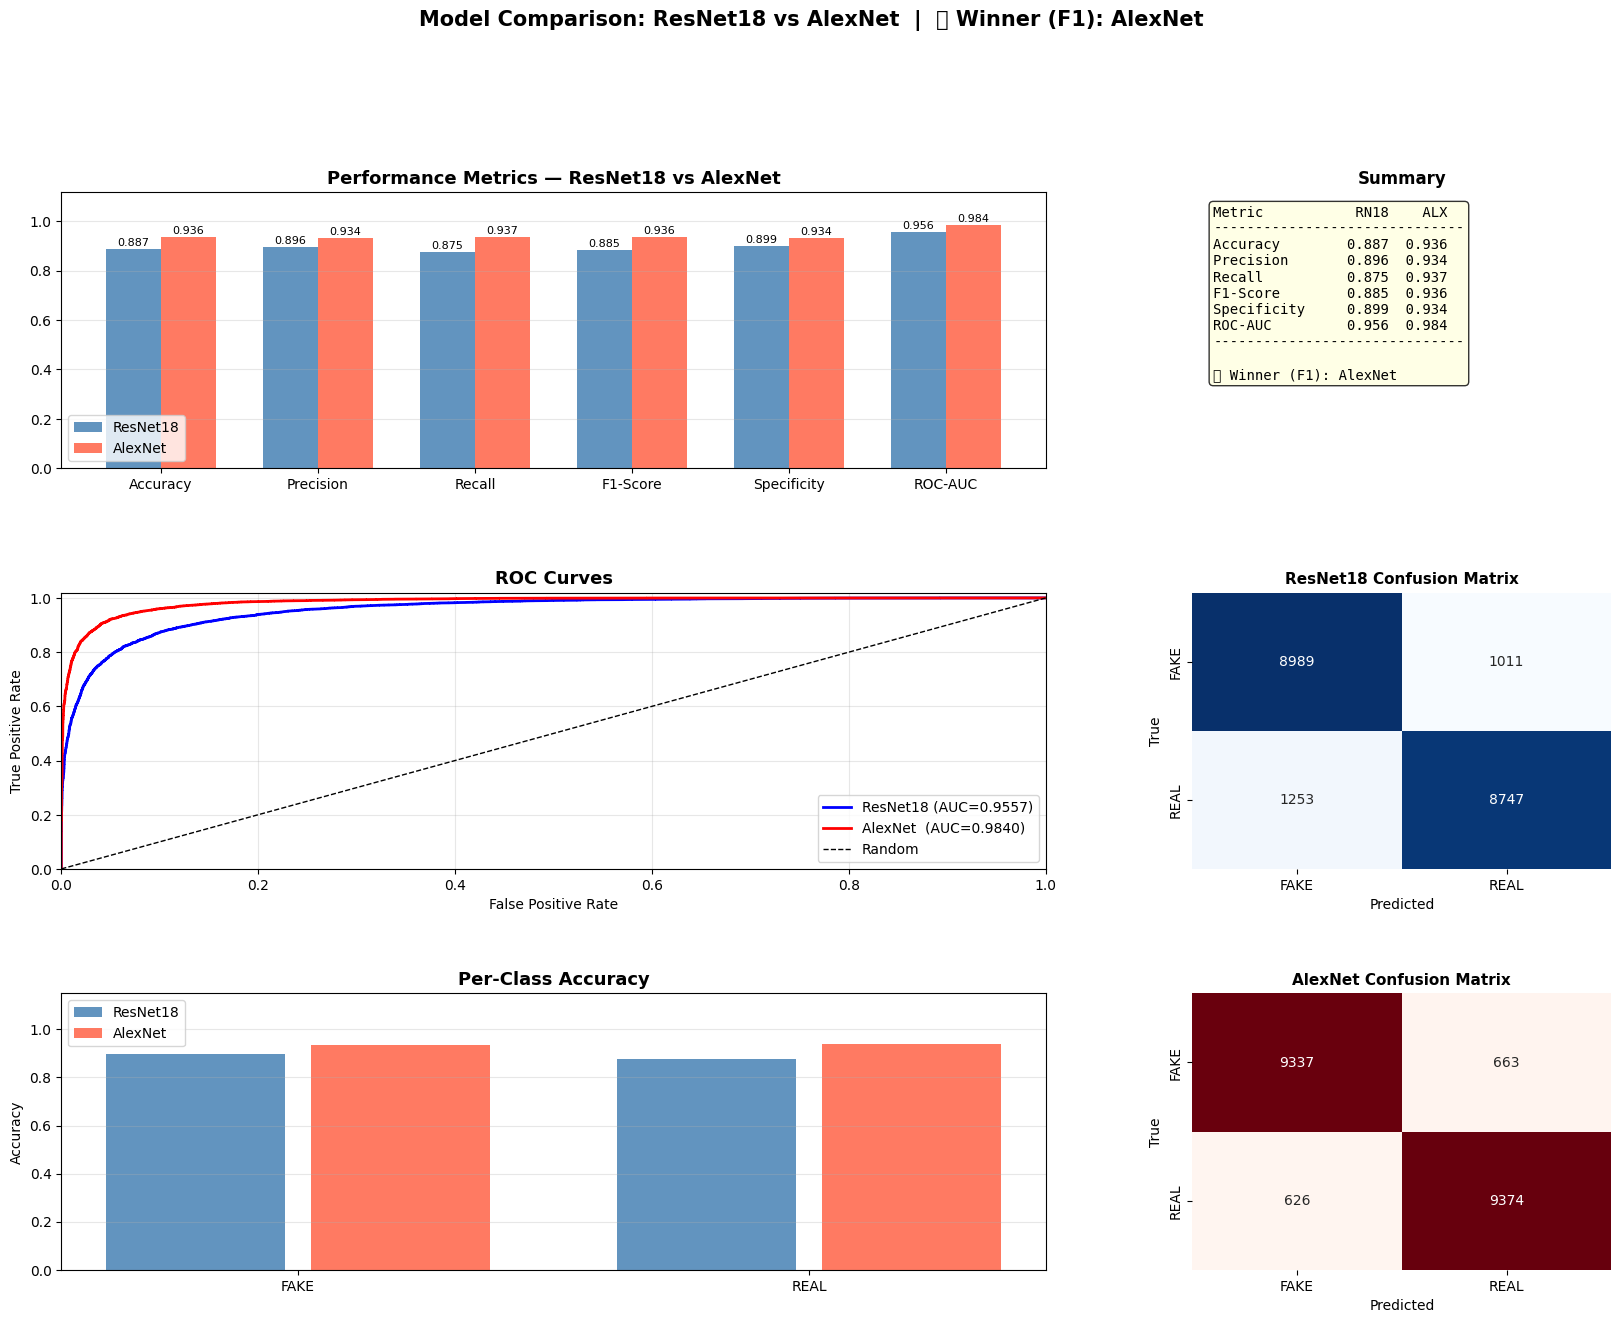

Saved: comparison_dashboard.png


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


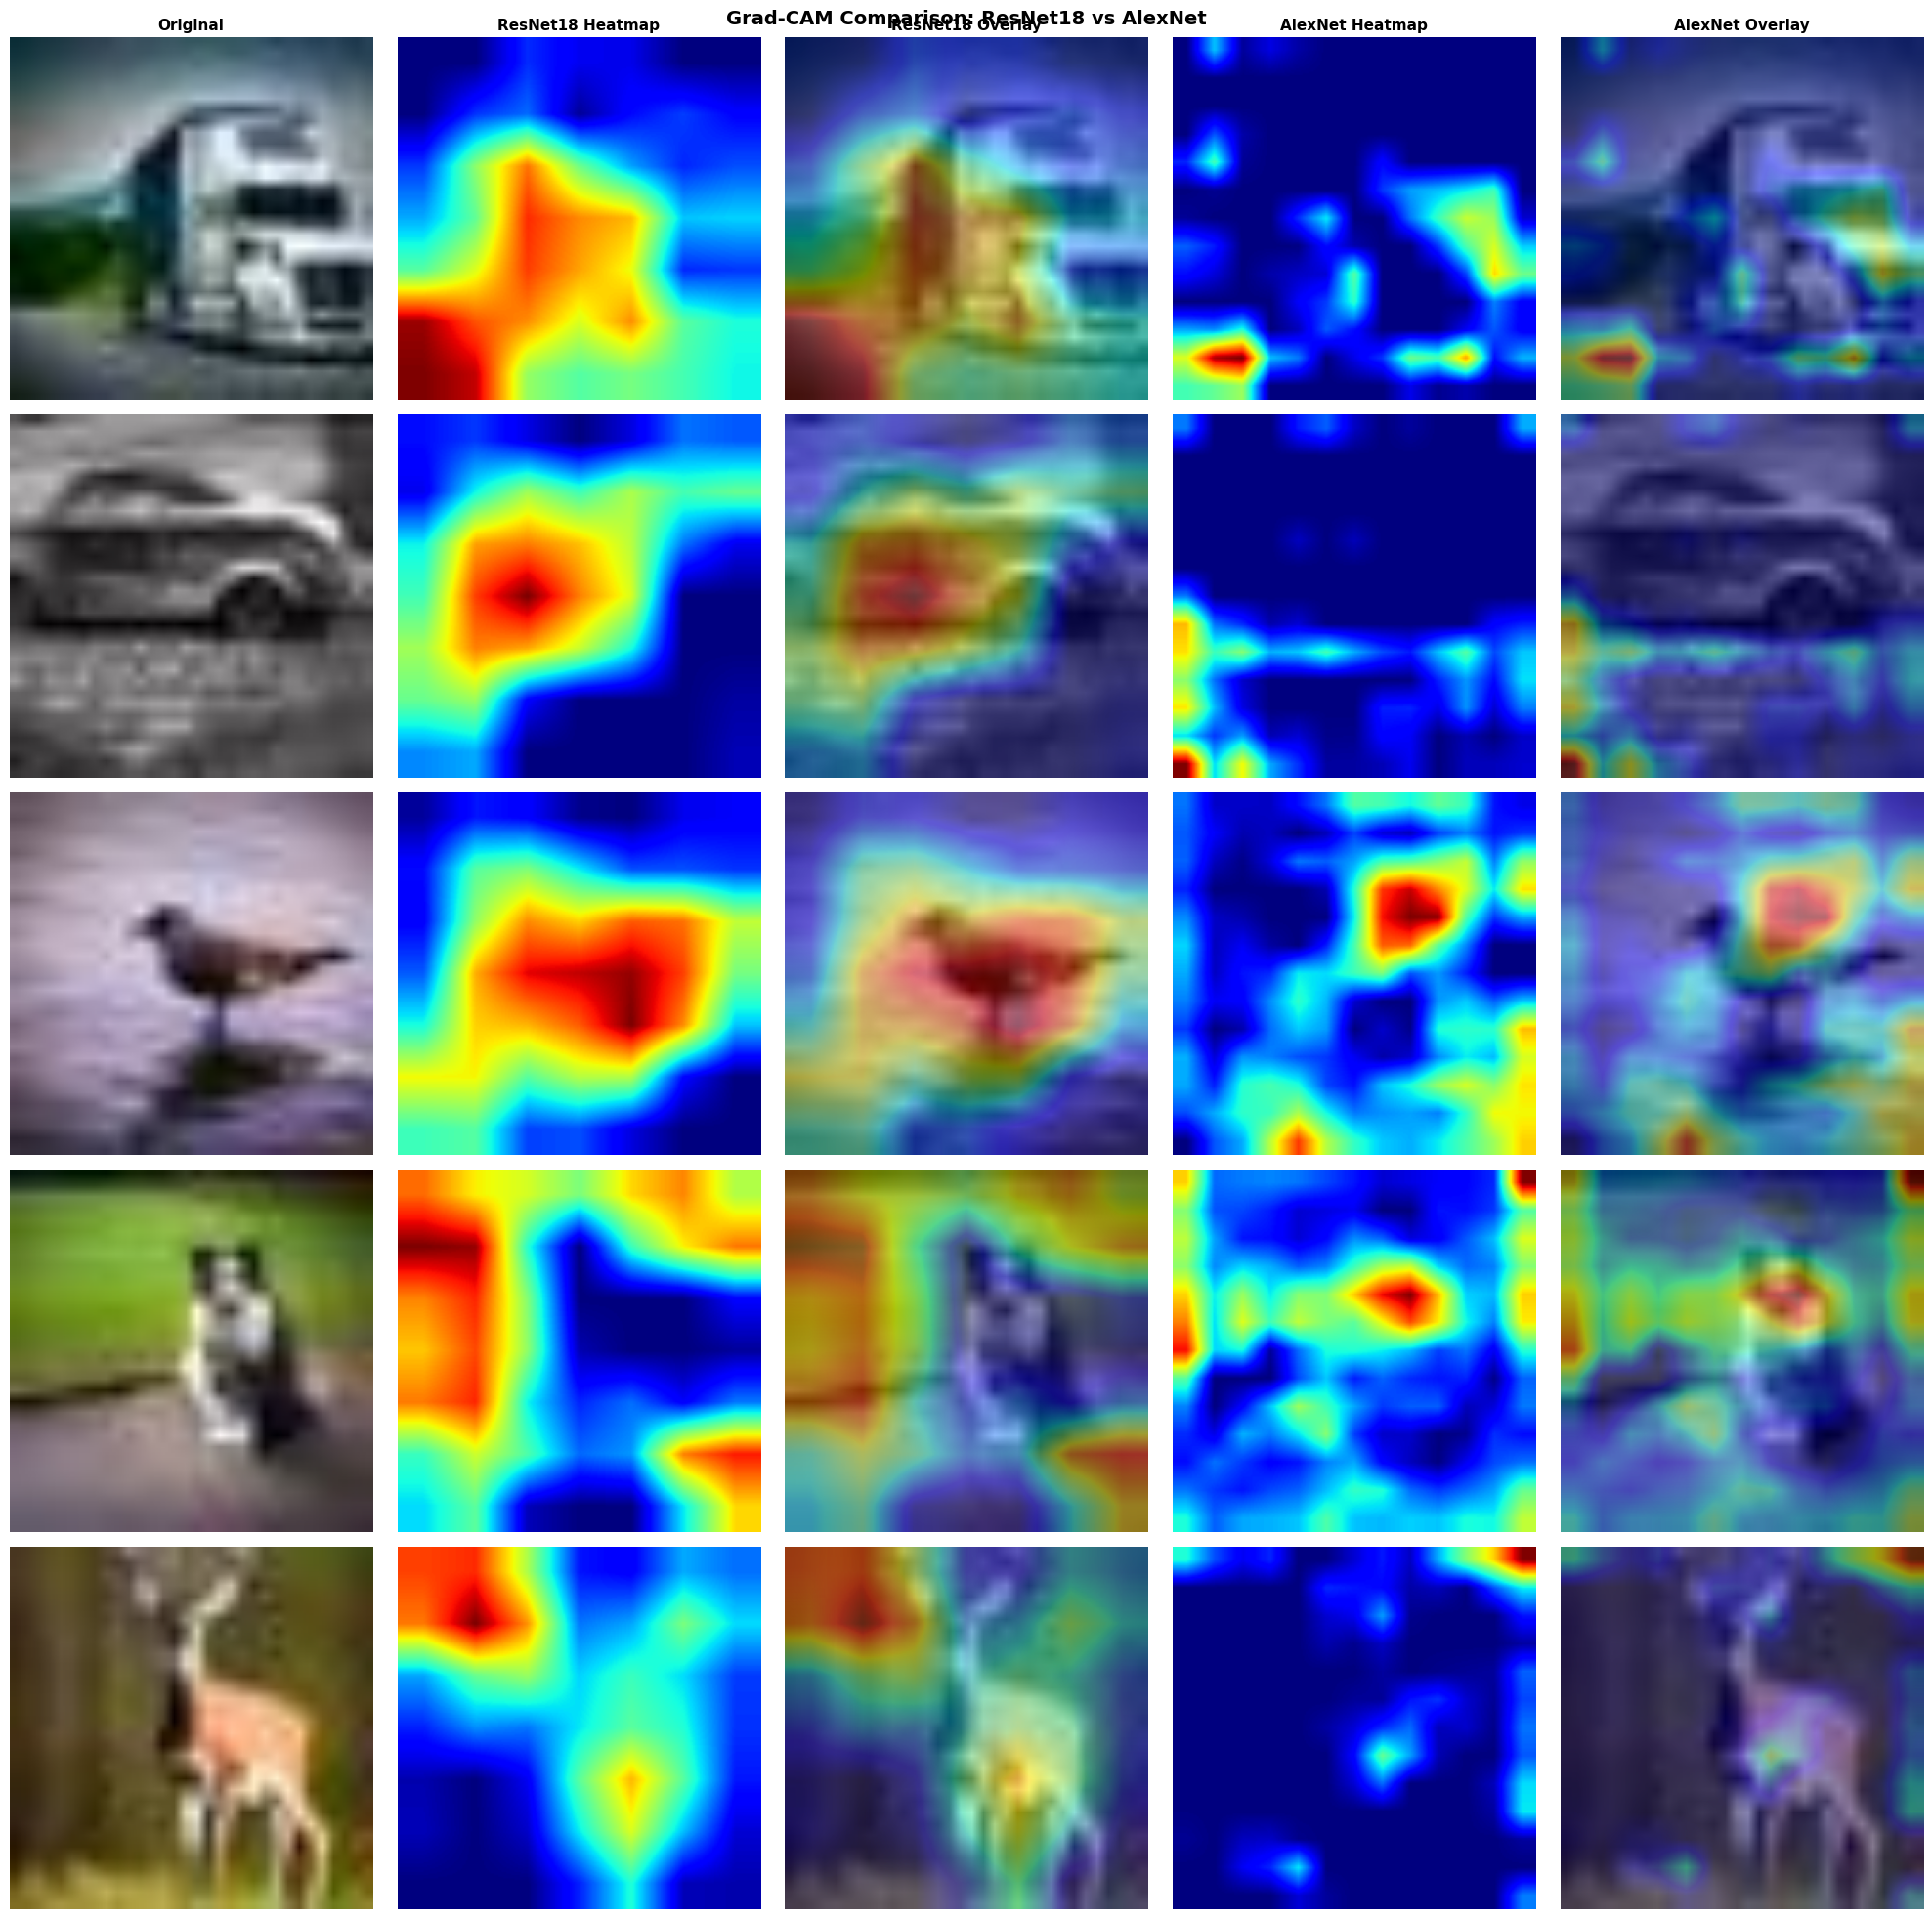

Saved: gradcam_comparison.png

             FINAL COMPARISON SUMMARY
Metric                 ResNet18      AlexNet      Winner
------------------------------------------------------------
Accuracy                 0.8868       0.9355     AlexNet
Precision                0.8964       0.9339     AlexNet
Recall                   0.8747       0.9374     AlexNet
F1-Score                 0.8854       0.9357     AlexNet
Specificity              0.8989       0.9337     AlexNet
ROC-AUC                  0.9557       0.9840     AlexNet
Overall Winner (F1-Score): AlexNet


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import cv2

# ── Data setup ────────────────────────────────────────────────
train_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_dir  = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset       = datasets.ImageFolder(test_dir,  transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
class_names = full_train_dataset.classes
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device : {device}")
print(f"Classes: {class_names}")

# ================================================================
# 1. LOAD BOTH MODELS FROM PTH FILES
# ================================================================

# ── ResNet18 ──────────────────────────────────────────────────
resnet_model = models.resnet18(pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
resnet_model.load_state_dict(torch.load('best_model.pth', map_location=device))
resnet_model = resnet_model.to(device)
resnet_model.eval()
print("✅ ResNet18 loaded from best_model.pth")

# ── AlexNet ───────────────────────────────────────────────────
alexnet_model = models.alexnet(pretrained=False)
alexnet_model.classifier[6] = nn.Linear(
    alexnet_model.classifier[6].in_features, 2
)
alexnet_model.load_state_dict(torch.load('best_alexnet.pth', map_location=device))
alexnet_model = alexnet_model.to(device)
alexnet_model.eval()
print("✅ AlexNet  loaded from best_alexnet.pth")

# ================================================================
# 2. COMPUTE METRICS
# ================================================================
def compute_full_metrics(model, loader, model_name):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs   = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(probs[:, 1].cpu().numpy())

    y_true   = np.array(y_true)
    y_pred   = np.array(y_pred)
    y_scores = np.array(y_scores)

    cm_mat = confusion_matrix(y_true, y_pred)
    tp, fp = cm_mat[1,1], cm_mat[0,1]
    fn, tn = cm_mat[1,0], cm_mat[0,0]

    accuracy    = np.mean(y_true == y_pred)
    precision   = tp/(tp+fp)   if (tp+fp)>0   else 0
    recall      = tp/(tp+fn)   if (tp+fn)>0   else 0
    f1          = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0
    specificity = tn/(tn+fp)   if (tn+fp)>0   else 0
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc     = auc(fpr, tpr)

    print(f"\n--- {model_name} Test Metrics ---")
    for name, val in [("Accuracy", accuracy), ("Precision", precision),
                      ("Recall", recall), ("F1-Score", f1),
                      ("Specificity", specificity), ("ROC-AUC", roc_auc)]:
        print(f"  {name:<14}: {val:.4f}")
    print(f"  Confusion Matrix:\n{cm_mat}")

    return dict(accuracy=accuracy, precision=precision, recall=recall,
                f1=f1, specificity=specificity, roc_auc=roc_auc,
                conf_matrix=cm_mat, fpr=fpr, tpr=tpr)

print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)
metrics_r = compute_full_metrics(resnet_model,  test_loader, "ResNet18")
metrics_a = compute_full_metrics(alexnet_model, test_loader, "AlexNet")

# ================================================================
# 3. COMPARISON DASHBOARD
# ================================================================
def plot_dashboard(m_r, m_a):
    keys   = ['accuracy','precision','recall','f1','specificity','roc_auc']
    labels = ['Accuracy','Precision','Recall','F1-Score','Specificity','ROC-AUC']
    vr     = [m_r[k] for k in keys]
    va     = [m_a[k] for k in keys]
    winner = "ResNet18" if m_r['f1'] >= m_a['f1'] else "AlexNet"

    fig = plt.figure(figsize=(20, 14))
    gs  = gridspec.GridSpec(3, 3, figure=fig, hspace=0.45, wspace=0.35)

    # ── Grouped metric bars ───────────────────────────────────
    ax1 = fig.add_subplot(gs[0, :2])
    x, w = np.arange(len(labels)), 0.35
    b1 = ax1.bar(x-w/2, vr, w, label='ResNet18', color='steelblue', alpha=0.85)
    b2 = ax1.bar(x+w/2, va, w, label='AlexNet',  color='tomato',    alpha=0.85)
    for b in list(b1)+list(b2):
        ax1.text(b.get_x()+b.get_width()/2, b.get_height()+0.005,
                 f'{b.get_height():.3f}', ha='center', va='bottom', fontsize=8)
    ax1.set_xticks(x); ax1.set_xticklabels(labels)
    ax1.set_ylim(0, 1.12)
    ax1.set_title('Performance Metrics — ResNet18 vs AlexNet', fontsize=13, fontweight='bold')
    ax1.legend(); ax1.grid(axis='y', alpha=0.3)

    # ── Winner callout ────────────────────────────────────────
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.axis('off')
    summary = "\n".join([
        f"{'Metric':<14} {'RN18':>6} {'ALX':>6}",
        "-"*30,
        *[f"{l:<14} {m_r[k]:>6.3f} {m_a[k]:>6.3f}" for k, l in zip(keys, labels)],
        "-"*30,
        f"\n🏆 Winner (F1): {winner}"
    ])
    ax2.text(0.05, 0.95, summary, transform=ax2.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    ax2.set_title('Summary', fontsize=12, fontweight='bold')

    # ── ROC curves ────────────────────────────────────────────
    ax3 = fig.add_subplot(gs[1, :2])
    ax3.plot(m_r['fpr'], m_r['tpr'], 'b-', lw=2,
             label=f"ResNet18 (AUC={m_r['roc_auc']:.4f})")
    ax3.plot(m_a['fpr'], m_a['tpr'], 'r-', lw=2,
             label=f"AlexNet  (AUC={m_a['roc_auc']:.4f})")
    ax3.plot([0,1],[0,1],'k--', lw=1, label='Random')
    ax3.set_xlim([0,1]); ax3.set_ylim([0,1.02])
    ax3.set_xlabel('False Positive Rate'); ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curves', fontsize=13, fontweight='bold')
    ax3.legend(loc='lower right'); ax3.grid(alpha=0.3)

    # ── Confusion matrix ResNet18 ─────────────────────────────
    ax4 = fig.add_subplot(gs[1, 2])
    sns.heatmap(m_r['conf_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax4, cbar=False)
    ax4.set_title('ResNet18 Confusion Matrix', fontsize=11, fontweight='bold')
    ax4.set_xlabel('Predicted'); ax4.set_ylabel('True')

    # ── Confusion matrix AlexNet ──────────────────────────────
    ax5 = fig.add_subplot(gs[2, 2])
    sns.heatmap(m_a['conf_matrix'], annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names, ax=ax5, cbar=False)
    ax5.set_title('AlexNet Confusion Matrix', fontsize=11, fontweight='bold')
    ax5.set_xlabel('Predicted'); ax5.set_ylabel('True')

    # ── Per-class accuracy bar ────────────────────────────────
    ax6 = fig.add_subplot(gs[2, :2])
    for cm_mat, name, color in [(m_r['conf_matrix'],'ResNet18','steelblue'),
                                 (m_a['conf_matrix'],'AlexNet', 'tomato')]:
        per_class = cm_mat.diagonal() / cm_mat.sum(axis=1)
        xpos = np.arange(len(class_names))
        offset = -0.2 if name == 'ResNet18' else 0.2
        ax6.bar(xpos + offset, per_class, 0.35, label=name, color=color, alpha=0.85)
    ax6.set_xticks(np.arange(len(class_names)))
    ax6.set_xticklabels(class_names)
    ax6.set_ylim(0, 1.15); ax6.set_ylabel('Accuracy')
    ax6.set_title('Per-Class Accuracy', fontsize=13, fontweight='bold')
    ax6.legend(); ax6.grid(axis='y', alpha=0.3)

    fig.suptitle(f"Model Comparison: ResNet18 vs AlexNet  |  🏆 Winner (F1): {winner}",
                 fontsize=15, fontweight='bold', y=1.01)
    plt.savefig('comparison_dashboard.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: comparison_dashboard.png")

plot_dashboard(metrics_r, metrics_a)

# ================================================================
# 4. GRAD-CAM SIDE-BY-SIDE
# ================================================================
# Enable gradients for Grad-CAM
for p in resnet_model.parameters():  p.requires_grad = True
for p in alexnet_model.parameters(): p.requires_grad = True

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm(tensor):
    x = tensor.cpu().clone() * IMAGENET_STD + IMAGENET_MEAN
    return np.clip(x.permute(1,2,0).numpy(), 0, 1)

class GradCAM:
    def __init__(self, model, layer):
        self.model = model; self.grads = None; self.acts = None
        layer.register_forward_hook(lambda m,i,o: setattr(self,'acts',o))
        layer.register_backward_hook(lambda m,gi,go: setattr(self,'grads',go[0]))

    def generate(self, img_t, class_idx=None):
        self.model.zero_grad()
        out = self.model(img_t)
        idx = class_idx if class_idx is not None else torch.argmax(out,1).item()
        out[0, idx].backward()
        w   = torch.mean(self.grads, dim=(2,3), keepdim=True)
        cam = torch.relu(torch.sum(w * self.acts, dim=1)).squeeze()
        cam = cam.detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, idx

# ResNet18 → layer4 (7×7 maps) | AlexNet → features[10] (6×6 maps)
gc_r = GradCAM(resnet_model,  resnet_model.layer4)
gc_a = GradCAM(alexnet_model, alexnet_model.features[10])

def visualize_gradcam(indices):
    n    = len(indices)
    fig, axes = plt.subplots(n, 5, figsize=(20, 4*n))
    if n == 1: axes = axes[np.newaxis, :]

    for col, title in enumerate(['Original',
                                  'ResNet18 Heatmap','ResNet18 Overlay',
                                  'AlexNet Heatmap', 'AlexNet Overlay']):
        axes[0, col].set_title(title, fontsize=11, fontweight='bold')

    for row, idx in enumerate(indices):
        img, label = test_dataset[idx]
        img_t = img.unsqueeze(0).to(device)

        cam_r, pred_r = gc_r.generate(img_t.clone())
        cam_a, pred_a = gc_a.generate(img_t.clone())

        cam_r = cv2.resize(cam_r, (224, 224))
        cam_a = cv2.resize(cam_a, (224, 224))
        orig  = denorm(img)

        axes[row,0].imshow(orig)
        axes[row,0].set_ylabel(f"True: {class_names[label]}", fontsize=9)

        axes[row,1].imshow(cam_r, cmap='jet')
        axes[row,2].imshow(orig)
        axes[row,2].imshow(cam_r, cmap='jet', alpha=0.45)
        axes[row,2].set_xlabel(f"Pred: {class_names[pred_r]}", fontsize=9)

        axes[row,3].imshow(cam_a, cmap='jet')
        axes[row,4].imshow(orig)
        axes[row,4].imshow(cam_a, cmap='jet', alpha=0.45)
        axes[row,4].set_xlabel(f"Pred: {class_names[pred_a]}", fontsize=9)

        for ax in axes[row]: ax.axis('off')

    plt.suptitle("Grad-CAM Comparison: ResNet18 vs AlexNet",
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('gradcam_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: gradcam_comparison.png")

visualize_gradcam(indices=[0, 1, 2, 3, 4])

# ================================================================
# 5. CONSOLE SUMMARY TABLE
# ================================================================
keys   = ['accuracy','precision','recall','f1','specificity','roc_auc']
labels = ['Accuracy','Precision','Recall','F1-Score','Specificity','ROC-AUC']
winner = "ResNet18" if metrics_r['f1'] >= metrics_a['f1'] else "AlexNet"

print("\n" + "="*60)
print("             FINAL COMPARISON SUMMARY")
print("="*60)
print(f"{'Metric':<18} {'ResNet18':>12} {'AlexNet':>12}  {'Winner':>10}")
print("-"*60)
for k, label in zip(keys, labels):
    vr_v, va_v = metrics_r[k], metrics_a[k]
    w = "ResNet18" if vr_v >= va_v else "AlexNet"
    print(f"{label:<18} {vr_v:>12.4f} {va_v:>12.4f}  {w:>10}")
print("="*60)
print(f"Overall Winner (F1-Score): {winner}")
print("="*60)

UI+DEPLOY